# 1 Data Cleaning and Preparation

## 1.1 Cleaning Main Bluebikes dataset

To start things off, we will import a few libraries that are pretty universally useful. They will be needed later.
We also set the style of visualizations to `matplotlib %inline`, so that this notebook won't be too bloated 
with interactive visualizations.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")
import folium
from folium import plugins
from folium.plugins import HeatMap
import math
import random
import timeit

We import the dataset with the data from the bikesharing platform **Bluebikes** from Boston 2018 and take
an initial look at it.

In [4]:
boston_2018_data = pd.read_csv('/Users/berra/Downloads/resources/boston_2018.csv')
boston_2018_data.head(10)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2018-01-01 00:16:33,2018-01-01 00:23:01,178,107,MIT Pacific St at Purrington St,Ames St at Main St,643,Subscriber
1,2018-01-01 00:42:00,2018-01-01 00:46:25,78,225,Union Square - Somerville,Cambridge Dept. of Public Works -147 Hampshire...,1581,Subscriber
2,2018-01-01 00:42:44,2018-01-01 01:02:11,16,76,Back Bay T Stop - Dartmouth St at Stuart St,Central Sq Post Office / Cambridge City Hall a...,173,Subscriber
3,2018-01-01 00:56:50,2018-01-01 01:11:06,69,177,Coolidge Corner - Beacon St @ Centre St,University Park,1772,Subscriber
4,2018-01-01 01:07:54,2018-01-01 01:16:02,4,46,Tremont St at E Berkeley St,Christian Science Plaza - Massachusetts Ave at...,1183,Subscriber
5,2018-01-01 01:15:59,2018-01-01 01:17:21,31,186,Seaport Hotel - Congress St at Seaport Ln,Congress St at Northern Ave,1793,Subscriber
6,2018-01-01 01:35:37,2018-01-01 01:42:35,51,222,Washington St at Lenox St,Troy Boston,60,Subscriber
7,2018-01-01 01:35:46,2018-01-01 01:45:11,189,178,Kendall T,MIT Pacific St at Purrington St,371,Subscriber
8,2018-01-01 01:45:04,2018-01-01 01:53:40,108,176,Harvard University / SEAS Cruft-Pierce Halls a...,Lesley University,961,Subscriber
9,2018-01-01 01:56:58,2018-01-01 02:06:13,185,178,Third at Binney,MIT Pacific St at Purrington St,1286,Subscriber


We then check for any missing data in the dataset.

In [5]:
len(boston_2018_data)-len(boston_2018_data.dropna())

0

There doesn't seem to be any data missing. But we just acted like there was and cleaned it regardless, as this
code could be transferred to other datasets from Bluebikes and if there would be missing data, we would know what to do.

We would choose to drop any missing data, because most of the data contained in the dataset is in nominal scale,
like the station names or ids, the user types, the bike ids, or in ordinal scale, like the start and end times.
It doesn't make sense to fill such data with averages or previous values, as this would just distort the data.

In [6]:
boston_2018_data_clean = boston_2018_data.dropna(axis=0)

Now when checking the data manually for irregularities, we note that he start and end times start with just seconds as the smallest unit, but somewhere in the data start including milliseconds.

In [7]:
boston_2018_data_clean.head(1000000)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2018-01-01 00:16:33,2018-01-01 00:23:01,178,107,MIT Pacific St at Purrington St,Ames St at Main St,643,Subscriber
1,2018-01-01 00:42:00,2018-01-01 00:46:25,78,225,Union Square - Somerville,Cambridge Dept. of Public Works -147 Hampshire...,1581,Subscriber
2,2018-01-01 00:42:44,2018-01-01 01:02:11,16,76,Back Bay T Stop - Dartmouth St at Stuart St,Central Sq Post Office / Cambridge City Hall a...,173,Subscriber
3,2018-01-01 00:56:50,2018-01-01 01:11:06,69,177,Coolidge Corner - Beacon St @ Centre St,University Park,1772,Subscriber
4,2018-01-01 01:07:54,2018-01-01 01:16:02,4,46,Tremont St at E Berkeley St,Christian Science Plaza - Massachusetts Ave at...,1183,Subscriber
...,...,...,...,...,...,...,...,...
999995,2018-08-15 18:25:56.7200,2018-08-15 18:56:06.9810,35,32,Arch St at Franklin St,Landmark Center - Brookline Ave at Park Dr,838,Subscriber
999996,2018-08-15 18:25:55.7250,2018-08-15 18:32:33.6170,139,87,Dana Park,Harvard University Housing - 115 Putnam Ave at...,3189,Subscriber
999997,2018-08-15 18:25:58.2320,2018-08-15 18:32:30.2600,80,178,MIT Stata Center at Vassar St / Main St,MIT Pacific St at Purrington St,99,Subscriber
999998,2018-08-15 18:25:56.3940,2018-08-16 09:18:15.8990,52,36,Newbury St at Hereford St,Copley Square - Dartmouth St at Boylston St,3199,Subscriber


As we would like to have a comparable and uniform dataset, we just remove the milliseconds from all start and end times.

In [8]:
def clean_date(x):
    return x.split('.')[0]

boston_2018_data_clean['start_time'] = boston_2018_data_clean['start_time'].apply(lambda x: clean_date(x))
boston_2018_data_clean['end_time'] = boston_2018_data_clean['end_time'].apply(lambda x: clean_date(x))
boston_2018_data_clean.head(1000000)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2018-01-01 00:16:33,2018-01-01 00:23:01,178,107,MIT Pacific St at Purrington St,Ames St at Main St,643,Subscriber
1,2018-01-01 00:42:00,2018-01-01 00:46:25,78,225,Union Square - Somerville,Cambridge Dept. of Public Works -147 Hampshire...,1581,Subscriber
2,2018-01-01 00:42:44,2018-01-01 01:02:11,16,76,Back Bay T Stop - Dartmouth St at Stuart St,Central Sq Post Office / Cambridge City Hall a...,173,Subscriber
3,2018-01-01 00:56:50,2018-01-01 01:11:06,69,177,Coolidge Corner - Beacon St @ Centre St,University Park,1772,Subscriber
4,2018-01-01 01:07:54,2018-01-01 01:16:02,4,46,Tremont St at E Berkeley St,Christian Science Plaza - Massachusetts Ave at...,1183,Subscriber
...,...,...,...,...,...,...,...,...
999995,2018-08-15 18:25:56,2018-08-15 18:56:06,35,32,Arch St at Franklin St,Landmark Center - Brookline Ave at Park Dr,838,Subscriber
999996,2018-08-15 18:25:55,2018-08-15 18:32:33,139,87,Dana Park,Harvard University Housing - 115 Putnam Ave at...,3189,Subscriber
999997,2018-08-15 18:25:58,2018-08-15 18:32:30,80,178,MIT Stata Center at Vassar St / Main St,MIT Pacific St at Purrington St,99,Subscriber
999998,2018-08-15 18:25:56,2018-08-16 09:18:15,52,36,Newbury St at Hereford St,Copley Square - Dartmouth St at Boylston St,3199,Subscriber


There don't seem to be any more irregularities after that, so we can move on to preparing the data for use

## 1.2 Preparing Bluebikes dataset

To analyze the dataset, we need to extract a few important pieces of data. We would like to be able to group our data by date, weekday, hour and month, so we need to extract that out of one of the time columns.

We choose the start_time, so the values extracted are from the start of the bike trip. It is important to keep that in mind.

**Important information:** These apply methods where the data is extracted can take a few minutes, due to them having
to go through the entire dataset. Patience is required.

In [9]:
def get_date(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()

def get_weekday(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()

def get_hour(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour

def get_month(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month

In [10]:
boston_2018_data_clean.reset_index(drop=True)
boston_2018_data_clean['date'] = boston_2018_data_clean['start_time'].apply(lambda x: get_date(x))

In [11]:
boston_2018_data_clean['weekday'] = boston_2018_data_clean['start_time'].apply(lambda x: get_weekday(x))

In [12]:
boston_2018_data_clean['hour'] = boston_2018_data_clean['start_time'].apply(lambda x: get_hour(x))

In [13]:
boston_2018_data_clean['month'] = boston_2018_data_clean['start_time'].apply(lambda x: get_month(x))

It looks like it has worked and we now have extra columns for the date, weekday, hour and month.

In [14]:
boston_2018_data_clean.head(5)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,date,weekday,hour,month
0,2018-01-01 00:16:33,2018-01-01 00:23:01,178,107,MIT Pacific St at Purrington St,Ames St at Main St,643,Subscriber,2018-01-01,0,0,1
1,2018-01-01 00:42:00,2018-01-01 00:46:25,78,225,Union Square - Somerville,Cambridge Dept. of Public Works -147 Hampshire...,1581,Subscriber,2018-01-01,0,0,1
2,2018-01-01 00:42:44,2018-01-01 01:02:11,16,76,Back Bay T Stop - Dartmouth St at Stuart St,Central Sq Post Office / Cambridge City Hall a...,173,Subscriber,2018-01-01,0,0,1
3,2018-01-01 00:56:50,2018-01-01 01:11:06,69,177,Coolidge Corner - Beacon St @ Centre St,University Park,1772,Subscriber,2018-01-01,0,0,1
4,2018-01-01 01:07:54,2018-01-01 01:16:02,4,46,Tremont St at E Berkeley St,Christian Science Plaza - Massachusetts Ave at...,1183,Subscriber,2018-01-01,0,1,1


## 1.3 Cleaning Bluebikes bike stations dataset

We now have a lot of data when and how long bike trips were, but we would also like to now where they started and where they ended. We already have the start station and end station names and ids, but we can't really do anything with that,
as we do not know where that is. That is why we also use the Bluebikes stations dataset to get some more geographical information.

We start by doing the same thing as with our initial dataset, just loading the data and taking a look at it.

In [15]:
bike_stations = pd.read_csv('resources/current_bluebikes_stations.csv')
bike_stations.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'resources/current_bluebikes_stations.csv'

It seems the columns are a bit off, as the first line of the dataset described when the data was last updated and 
the second line are the column headers. We fix that by just dropping the first line.

In [ ]:
bike_stations.columns = bike_stations.iloc[0]
bike_stations.drop(bike_stations.index[0])

Like with the first dataset, we check for missing data and would drop it, but there is none.

In [ ]:
len(bike_stations) - len(bike_stations.dropna())

Now, as we have the name of the station, we can use that to assign the information from this dataset to our initial dataset by merging the data on the name column using `pd.merge`. We want to transfer both the start and the end location to a new combined dataset.

After that, we inspect it to see if it worked.

In [ ]:
boston_2018_start_geodata = pd.merge(boston_2018_data_clean, bike_stations[['Name','Latitude', 'Longitude', 'District']], left_on="start_station_name", right_on="Name", how="left")
boston_2018_start_geodata = boston_2018_start_geodata.rename(columns = {'Latitude': 'latitude_start', 'Longitude': 'longitude_start', "District": "district_start"})
boston_2018_start_geodata['start_coordinates'] = list(zip(boston_2018_start_geodata["latitude_start"],boston_2018_start_geodata["longitude_start"]))
del boston_2018_start_geodata['Name']

boston_2018_trip_geodata = pd.merge(boston_2018_start_geodata, bike_stations[['Name','Latitude', 'Longitude', 'District']], left_on="end_station_name", right_on="Name", how="left")
boston_2018_trip_geodata = boston_2018_trip_geodata.rename(columns = {'Latitude': 'latitude_end', 'Longitude': 'longitude_end', "District": "district_end"})
boston_2018_trip_geodata['end_coordinates'] = list(zip(boston_2018_trip_geodata["latitude_end"],boston_2018_trip_geodata["longitude_end"]))
del boston_2018_trip_geodata['Name']

boston_2018_trip_geodata.head(5)

It seems to have worked, but we can already spot a NaN value in the first five values. This is due to not every station name in the initial dataset being compatible with a station name in the station dataset. Looking at the amount of missing values, we need to do some cleaning. 

In [ ]:
len(boston_2018_trip_geodata)-len(boston_2018_trip_geodata.dropna())

We will just drop any missing data, as we can not use it for geographical purposes and it makes no sense to have a combined dataset when one half is missing. We can always use the main dataset for those purposes.

In [ ]:
boston_2018_trip_geodata_clean = boston_2018_trip_geodata.dropna()
len(boston_2018_trip_geodata_clean)-len(boston_2018_trip_geodata_clean.dropna())

## 1.4 Cleaning Boston weather dataset

It seems very likely that the weather also plays a big role in a bike sharing platform. Assuming that people usually don't like to ride a bike in rain or at freezing temperatures seems pretty intuitive.
That is why we also include a weather dataset for boston.

We proceed as we did with the previous datasets and load it first to look at it.

In [ ]:
boston_weather = pd.read_csv('resources/weather_hourly_boston.csv')
boston_weather.head(10)

There doesn't seem to be anything special in this dataset, so we continue cleaning it.

In [ ]:
len(boston_weather) - len(boston_weather.dropna())

We drop the missing values, because they don't provide any valuable information and can be excluded.

In [ ]:
boston_weather_clean = boston_weather.dropna()
len(boston_weather_clean) - len(boston_weather_clean.dropna())

We now prepare to merge it with the main dataset. To do that, we extract the hour and the date from the date_time column, as we have exactly the same columns in our main dataset and these two form a unique identifier for each row.

In [ ]:
boston_weather_clean.reset_index(drop=True)
pd.options.mode.chained_assignment = None
boston_weather_clean['date'] = boston_weather_clean['date_time'].apply(lambda x:get_date(x))
boston_weather_clean['hour'] = boston_weather_clean['date_time'].apply(lambda x:get_hour(x))
boston_weather_clean.head(10)

We then just merge the data with our main dataset on the date and hour columns using `pd.merge` and take a look at the data.

In [ ]:
boston_2018_trip_geodata_with_temp = pd.merge(boston_2018_trip_geodata_clean, 
                                              boston_weather_clean[['max_temp','min_temp', 'precip', 'date', 'hour']],
                                              on=['date', 'hour'], how="left")
boston_2018_trip_geodata_with_temp.head(5)

As with the geographical data, we need to take a look at missing data afterwards, due to the fact that some days or hours may be missing in the temperature dataset.

In [ ]:
len(boston_2018_trip_geodata_with_temp)-len(boston_2018_trip_geodata_with_temp.dropna())

Again the same as with the geographical dataset, missing data doesn't provide any value, so we just drop it.

In [ ]:
boston_2018_trip_geodata_with_temp_clean = boston_2018_trip_geodata_with_temp.dropna()
len(boston_2018_trip_geodata_with_temp_clean)-len(boston_2018_trip_geodata_with_temp_clean.dropna())

We now have several datasets containing much information and can move on to visualize it to get a better understanding of the data.

# 2 Descriptive Analytics

## 2.1 Temporal Demand Patterns

In this part of our project we want to know how many bikes where borrowed in one day, one week and one year. For this we plot three different visualizations to see how it changed through the times we want to analyze. 

In [24]:
#create a column with weekday names 
weeday_dict = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}

boston_2018_data_clean["Weekday_name"] = boston_2018_data_clean["weekday"].apply(lambda x: weeday_dict[x])

For a better look at the x axis we create a column with weekday names instead of numbers

In [25]:
#create a column with month names
month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}

boston_2018_data_clean["month_name"] = boston_2018_data_clean["month"].apply(lambda x: month_dict[x])

For the same reasons we also create a column with months names

In [26]:
#create a new column with an ascending index of each row
Bike_anzahl=boston_2018_data_clean.index

boston_2018_data_clean["Bike_Anzahl"]= Bike_anzahl

Next we create a column with an ascending index of each row to differentiate every single rent of the bike through the year. In the next step we use the groupby Statement to order every rent to its date and hour. After this we can plot the quantity of borrowed bikes with a boxplot to see variance and the minimum/maximum value

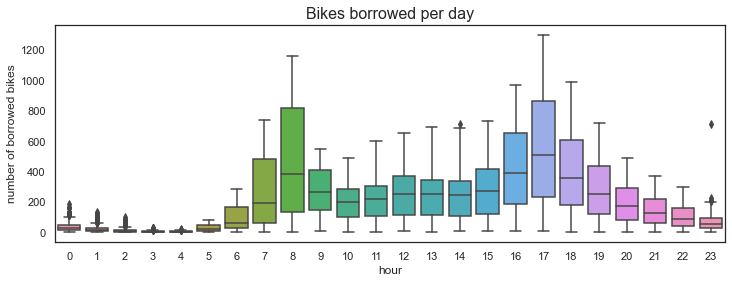

In [27]:
#create a boxplot of borrowed bikes per day
boston_tempered_hour = boston_2018_data_clean.groupby(["date","hour"])["Bike_Anzahl"].nunique()
boston_tempered_hour= pd.DataFrame(boston_tempered_hour)
fig,ax = plt.subplots(figsize=(12,4)) 

sns.boxplot(x=boston_tempered_hour.index.get_level_values(1), y=boston_tempered_hour["Bike_Anzahl"],ax=ax)
ax.set_title("Bikes borrowed per day",fontsize=16)
plt.ylabel('number of borrowed bikes')
#plt.savefig("daydemand.pdf")
plt.show()

The same boxplot with week instead of day

In [ ]:
#create a boxplot of borrowed bikes per week
boston_tempered_weekday = boston_2018_data_clean.groupby(["date","Weekday_name"])["Bike_Anzahl"].nunique()
boston_tempered_weekday= pd.DataFrame(boston_tempered_weekday)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=boston_tempered_weekday.index.get_level_values(1), y=boston_tempered_weekday["Bike_Anzahl"],ax=ax)
ax.set_title("Bikes borrowed per week",fontsize=16)
plt.xlabel('weekday')
plt.ylabel('number of borrowed bikes')
#plt.savefig("weekdemand.pdf")
plt.show()

To plot the year demand, we create a column with 1 in every row to count the values for every month

In [ ]:
#create a column with index 1 in every row
month_dict2 = {1:"1",2:"1",3:"1",4:"1",5:"1",6:"1",7:"1",8:"1",9:"1",10:"1",11:"1",12:"1"}

boston_2018_data_clean["Index"] = boston_2018_data_clean["month"].apply(lambda x: month_dict2[x])

In [ ]:
#calculate the number of borrowed bikes for every month
Jan = boston_2018_data_clean[boston_2018_data_clean["month"]==1].groupby("Index").count()
Feb = boston_2018_data_clean[boston_2018_data_clean["month"]==2].groupby("Index").count()
Mar = boston_2018_data_clean[boston_2018_data_clean["month"]==3].groupby("Index").count()
Apr = boston_2018_data_clean[boston_2018_data_clean["month"]==4].groupby("Index").count()
May = boston_2018_data_clean[boston_2018_data_clean["month"]==5].groupby("Index").count()
Jun = boston_2018_data_clean[boston_2018_data_clean["month"]==6].groupby("Index").count()
Jul = boston_2018_data_clean[boston_2018_data_clean["month"]==7].groupby("Index").count()
Aug = boston_2018_data_clean[boston_2018_data_clean["month"]==8].groupby("Index").count()
Sep = boston_2018_data_clean[boston_2018_data_clean["month"]==9].groupby("Index").count()
Oct = boston_2018_data_clean[boston_2018_data_clean["month"]==10].groupby("Index").count()
Nov = boston_2018_data_clean[boston_2018_data_clean["month"]==11].groupby("Index").count()
Dec = boston_2018_data_clean[boston_2018_data_clean["month"]==12].groupby("Index").count()

In [ ]:
#output the claculated table
Data = {"Jan": Jan['month'],
      "Feb": Feb['month'],
       "Mar": Mar['month'],
        "Apr": Apr['month'],
        "May": May['month'],
        "Jun": Jun['month'],
        "Jul": Jul['month'],
        "Aug": Aug['month'],
        "Sep": Sep['month'],
        "Oct": Oct['month'],
        "Nov": Nov['month'],
        "Dec": Dec['month']
       }

Year = pd.DataFrame(Data)
print(Year)

Next we create a new dataframe with the counted values for every month to plot it below

In [ ]:
#create a bar chart
datayear = {'month': ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'],
        'quantity': [40932,62817,62985,98194,178865,205359,242916,236076,236182,200100,121419,81961]
        }

Year2 = pd.DataFrame(datayear)

Because of the fact that we used data for one year, we plotted the demand with an barchart because of missing years to compare in a boxplot

In [ ]:
ax=Year2.plot.bar(x='month', y='quantity', rot=0, figsize=(14,6))
ax.set_title("Bikes borrowed in year 2018",fontsize=16)
plt.ylabel('number of borrowed bikes', fontsize=14)
plt.xlabel('month', fontsize=14)
#plt.savefig("yeardemand.pdf")
plt.show()

At the end of this part we count the different months to differentiate them into seasons

In [ ]:
#create a bar chart for seasons
data_season = {'season': ['Spring','Summer','Autumn','Winter'],
        'quantity': [340044,684351,557701,185710]
        }

season = pd.DataFrame(data_season)

In [ ]:
ax=season.plot.bar(x='season', y='quantity', rot=0, figsize=(14,6))
ax.set_title("Bikes borrowed in seasons",fontsize=16)
plt.ylabel('number of borrowed bikes', fontsize=14)
plt.xlabel('season', fontsize=14)
plt.savefig("seasondemand.pdf")
plt.show()

## 2.2 Geographical Demand Patterns

In [ ]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
sns.countplot(x="district_start",data=boston_2018_trip_geodata_clean, ax=axes[0], order=boston_2018_trip_geodata_clean['district_start'].value_counts().index)
sns.countplot(x="district_end",data=boston_2018_trip_geodata_clean, ax=axes[1], order=boston_2018_trip_geodata_clean['district_start'].value_counts().index)

## General Demand

In [ ]:
boston_2018_trip_geodata_clean["Coordinates"] = list(zip(boston_2018_trip_geodata_clean["latitude_start"],boston_2018_trip_geodata_clean["longitude_start"]))

In [ ]:
bike_list = boston_2018_trip_geodata_clean["bike_id"].unique()
selected_bike_ID = random.choice(bike_list)

In [ ]:
#define new map

demand_heat_map = folium.Map(location=(42.337510, -71.067966),tiles='Stamen Toner', 
                       zoom_start=12, control_scale=True, max_zoom=20)

# add heat map

demand_heat_map.add_child(plugins.HeatMap(boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["bike_id"]==selected_bike_ID]["Coordinates"], radius=20))

#add tilelayers 

folium.TileLayer('stamentoner').add_to(demand_heat_map)
folium.TileLayer('cartodbpositron').add_to(demand_heat_map)
folium.TileLayer('openstreetmap').add_to(demand_heat_map)
folium.LayerControl().add_to(demand_heat_map)

demand_heat_map

In [ ]:
# rows in which 'district_start' is 'specific one'
count_cambridge = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Cambridge" else False, axis = 1)
count_somerville = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Somerville" else False, axis = 1)
count_boston = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Boston" else False, axis = 1)
count_brookline = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Brookline" else False, axis = 1)

# rows in which 'district_end' is 'specific one'
count_cambridge = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Cambridge" else False, axis = 1)
count_somerville = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Somerville" else False, axis = 1)
count_boston = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Boston" else False, axis = 1)
count_brookline = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Brookline" else False, axis = 1)

# Count number of True in the series
num_rows_c = len(count_cambridge[count_cambridge == True].index)
num_rows_s = len(count_somerville[count_somerville == True].index)
num_rows_bo = len(count_boston[count_boston == True].index)
num_rows_br = len(count_brookline[count_brookline == True].index)

num_rows_c0 = len(count_cambridge[count_cambridge == True].index)
num_rows_s1 = len(count_somerville[count_somerville == True].index)
num_rows_bo2 = len(count_boston[count_boston == True].index)
num_rows_br3 = len(count_brookline[count_brookline == True].index)

# point = boston_2018_trip_geodata_clean.apply(lambda x: get_district_end(x))

data = {'Districts':  ['Cambridge', 'Boston', 'Brookline', 'Somerville'],
        'Number': [num_rows_c0 + num_rows_c, num_rows_bo2 + num_rows_bo, num_rows_br3 + num_rows_br, num_rows_s1 + num_rows_s]
        }

df = pd.DataFrame (data, columns = ['Districts','Number'])

g = sns.barplot(x="Districts", y="Number", data=df, palette="OrRd")
plt.show()


## Start Demand

In [ ]:
#define new map

s_demand_heat_map = folium.Map(location=(42.337510, -71.067966),  tiles='Stamen Toner', 
                       zoom_start=12, control_scale=True, max_zoom=20)

# add heat map

s_demand_heat_map.add_child(plugins.HeatMap(boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["bike_id"]==selected_bike_ID]["Coordinates"], radius=20))

#add tilelayers 

folium.TileLayer('stamentoner').add_to(s_demand_heat_map)
folium.TileLayer('cartodbpositron').add_to(s_demand_heat_map)
folium.TileLayer('openstreetmap').add_to(s_demand_heat_map)
folium.LayerControl().add_to(s_demand_heat_map)

s_demand_heat_map

In [ ]:
# rows in which 'district_start' is 'specific one'
count_cambridge = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Cambridge" else False, axis = 1)
count_somerville = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Somerville" else False, axis = 1)
count_boston = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Boston" else False, axis = 1)
count_brookline = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_start'] == "Brookline" else False, axis = 1)

# Count number of True in the series
num_rows_c0 = len(count_cambridge[count_cambridge == True].index)
num_rows_s1 = len(count_somerville[count_somerville == True].index)
num_rows_bo2 = len(count_boston[count_boston == True].index)
num_rows_br3 = len(count_brookline[count_brookline == True].index)

data = {'District_start':  ['Cambridge', 'Boston', 'Brookline', 'Somerville'],
        'Number': [num_rows_c0, num_rows_bo2, num_rows_br3, num_rows_s1]
        }

df = pd.DataFrame (data, columns = ['District_start','Number'])
print(df)

sns.barplot(x="District_start", y="Number", data=df, palette="OrRd")
plt.show()

## End Demand

In [ ]:
#define new map

e_demand_heat_map = folium.Map(location=(42.337510, -71.067966),  tiles='Stamen Terrain', 
                       zoom_start=12, control_scale=True, max_zoom=20)

# add heat map

e_demand_heat_map.add_child(plugins.HeatMap(boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["bike_id"]==selected_bike_ID]["Coordinates"], radius=20))

#add tilelayers 

folium.TileLayer('stamentoner').add_to(e_demand_heat_map)
folium.TileLayer('cartodbpositron').add_to(e_demand_heat_map)
folium.TileLayer('openstreetmap').add_to(e_demand_heat_map)
folium.LayerControl().add_to(e_demand_heat_map)

e_demand_heat_map

In [ ]:
# rows in which 'district_end' is 'specific one'
count_cambridge = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Cambridge" else False, axis = 1)
count_somerville = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Somerville" else False, axis = 1)
count_boston = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Boston" else False, axis = 1)
count_brookline = boston_2018_trip_geodata_clean.apply(lambda x : True
            if x['district_end'] == "Brookline" else False, axis = 1)

# Count number of True in the series
num_rows_c = len(count_cambridge[count_cambridge == True].index)
num_rows_s = len(count_somerville[count_somerville == True].index)
num_rows_bo = len(count_boston[count_boston == True].index)
num_rows_br = len(count_brookline[count_brookline == True].index)

data = {'District_end':  ['Cambridge', 'Boston', 'Brookline', 'Somerville'],
        'Number': [num_rows_c, num_rows_bo, num_rows_br, num_rows_s]
        }

df = pd.DataFrame (data, columns = ['District_end','Number'])
print(df) 

sns.barplot(x="District_end", y="Number", data=df, palette="OrRd")
plt.show()

## Compare start and end
Here you can see the difference between tour starts and tour ends in the districts. For example, a positive value means that there were more tour starts than tour ends in the respective district

In [ ]:
difference = {"District": ["Cambridge", "Boston", "Brookline", "Somerville"],
                "Difference": [(num_rows_c0-num_rows_c), (num_rows_bo2-num_rows_bo), (num_rows_br3-num_rows_br), (num_rows_s1-num_rows_s)]
}
diff = pd.DataFrame (difference, columns = ["District",'Difference'])
print(diff) 

sns.barplot(x="District", y="Difference", data=diff, palette="OrRd")
plt.show()

## Choropleth Map of Boston
### Convert lat and long coordinates into zipcodes  
This step takes much time. For 1000 conversions about 5 minutes. We convert the lang and long into the zip code.

In [ ]:
import geopy
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

#longlat = boston_2018_trip_geodata_clean
geolocator = geopy.Nominatim(user_agent="check_1")


    
def get_zip_code(x):
    location = geolocator.reverse("{}, {}".format(x['latitude_start'],x['longitude_start']))
    try:
        return (location.raw['address']['postcode'])
    except:
        return (None, None)
boston_2018_trip_geodata_clean['zipcode'] = boston_2018_trip_geodata_clean.head(1000).apply(lambda x: get_zip_code(x), axis = 1)
print(boston_2018_trip_geodata_clean.head(10))

### Choropleth map of greater boston 
In this visualization you can see boston and its surrounding districts. Here you can read and recognise the demand much better than in the heatmaps before. For this, the individual incidents are no longer precisely localised. 

In [ ]:
# definition of the boundaries in the map
boston_and_greater = r'boston_and_greater.json'

# calculating total number of incidents per district
data2 = pd.DataFrame(boston_2018_trip_geodata_clean['bike_id'].value_counts().astype(float))
data2.to_json('map.json')
data2 = data2.reset_index()
data2.columns = ['zipcode', 'bike_id']
  
# creation of the choropleth
simple_map = folium.Map(location=(42.337510, -71.067966), zoom_start=12)

#Boston and greater
folium.Choropleth(
    geo_data = boston_and_greater,
    name="Boston_and_greater",
    data=boston_2018_trip_geodata_clean,
    columns=["zipcode", 'bike_id'],
    key_on='feature.properties.ZIP5',
    fill_color="YlOrRd",
    fill_opacity=0.7,
   line_opacity=1.0,
).add_to(simple_map)

#add tilelayers 
folium.TileLayer('openstreetmap').add_to(simple_map)
folium.TileLayer('Stamen Terrain').add_to(simple_map)
folium.TileLayer('cartodbpositron').add_to(simple_map)
folium.LayerControl().add_to(simple_map)
               
display(simple_map)

In this map you can choose the districts you want to see through the layers and the layer control. For example, if you only want to see the demand in Brookline and Cambridge, then only pick these two in the layer control.

In [ ]:
# definition of the boundaries in the map
boston_and_greater = r'boston_and_greater.json'
Boston = r'ZIP_Codes.geojson'
Cambridge = r'Cambridge_Zipcodes.geojson'
Somerville = r'somerville.json'
Brookline = r'brookline.json'

# calculating total number of incidents per district
data2 = pd.DataFrame(boston_2018_trip_geodata_clean['bike_id'].value_counts().astype(float))
data2.to_json('map.json')
data2 = data2.reset_index()
data2.columns = ['zipcode', 'bike_id']
  
# creation of the choropleth
whole_map = folium.Map(location=(42.337510, -71.067966), zoom_start=12)

# Boston
folium.Choropleth(
    geo_data = Boston,
    name="Boston",
    data=boston_2018_trip_geodata_clean,
    columns=["zipcode", 'bike_id'],
    key_on='feature.properties.ZIP5',
    fill_color="Blues",
    fill_opacity=0.7,
   line_opacity=1.0,
    legend_name="Usage per district",
).add_to(whole_map)

# Somerville
folium.Choropleth(
    geo_data = Somerville,
    name="Somerville",
    data=boston_2018_trip_geodata_clean,
    columns=["zipcode", 'bike_id'],
    key_on='feature.properties.ZIP5',
    fill_color="Greens",
    fill_opacity=0.7,
   line_opacity=1.0,
    legend_name="Usage per district",
).add_to(whole_map)

# Cambridge
folium.Choropleth(
    geo_data = Cambridge,
    name="Cambridge",
    data=boston_2018_trip_geodata_clean,
    columns=["zipcode", 'bike_id'],
    key_on='feature.properties.ZIP_CODE',
    fill_color="Reds",
    fill_opacity=0.7,
   line_opacity=1.0,
).add_to(whole_map)

# Brookline
folium.Choropleth(
    geo_data = Brookline,
    name="Brookline",
    data=boston_2018_trip_geodata_clean,
    columns=["zipcode", 'bike_id'],
    key_on='feature.properties.ZIP5',
    fill_color="Purples",
    fill_opacity=0.7,
   line_opacity=1.0,
).add_to(whole_map)

        
#add tilelayers 
folium.TileLayer('openstreetmap').add_to(whole_map)
folium.TileLayer('Stamen Terrain').add_to(whole_map)
folium.TileLayer('cartodbpositron').add_to(whole_map)
folium.LayerControl().add_to(whole_map)
               
display(whole_map)

## 2.3 Key Performance Indicators (KPIs)

## Duration

To get the duration of a trip, we first convert start_tkme and end_time, which are strings, into datetime objects.
This makes getting time differences easier.

In [ ]:
def get_datetime(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    
boston_2018_data_clean['datetime_start'] = boston_2018_data_clean['start_time'].apply(lambda x: get_datetime(x))
boston_2018_data_clean['datetime_end'] = boston_2018_data_clean['end_time'].apply(lambda x: get_datetime(x))

After we now have the datetime objects, we can easily get the time difference from start time to end time to
get the duration of the trip.

In [ ]:
boston_2018_data_clean['duration'] = boston_2018_data_clean['datetime_end'] - boston_2018_data_clean['datetime_start']
boston_2018_data_clean.head(10)

We then convert that timedelta object to a simple number of minutes.

In [ ]:
def get_minutes(x):
    return (x.total_seconds())/60

boston_2018_data_clean['minutes'] = boston_2018_data_clean['duration'].apply(lambda x: get_minutes(x))
boston_2018_data_clean.head(100)

Then we can already visualize it. We use boxplots to show the medians and also visualize the deviations.

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(x = "hour", y = "minutes", data= boston_2018_data_clean, ax=axes, showfliers=False)
axes.set_title("Median duration of trip per hour throughout the year (KPI)")

## General demand

In [ ]:
#plot the total number of borrowed bikes for every hour in the year
boston_tempered_hour = boston_2018_data_clean.groupby(["Index","hour"])["Bike_Anzahl"].nunique()
boston_tempered_hour = pd.DataFrame(boston_tempered_hour)
fig,ax = plt.subplots(figsize=(12,4))
sns.barplot(x=boston_tempered_hour.index.get_level_values(1), y=boston_tempered_hour["Bike_Anzahl"],ax=ax)
ax.set_title("total number of bicycles per hour in the year",fontsize=16)
plt.ylabel('number of borrowed bikes')
plt.show()

## Proportion of the fleet 

To analyze the proportion of the fleet first we calculated the fleet size of our dataset

In [ ]:
#calculate the fleet size
fleet_size = len(boston_2018_data_clean["bike_id"].unique())
fleet_size

In [ ]:
#create a dataframe with the number of different bike IDs borrowed every hour
boston_tempered_hour123 = boston_2018_data_clean.groupby(["date","hour"])["bike_id"].nunique()
boston_tempered_hour123= pd.DataFrame(boston_tempered_hour123)

In [ ]:
boston_tempered_hour123

In this dataframe we see the number of different bike ids borrowed every hour. In the next step we divide it with the fleet size to get the proportion in percent.

In [ ]:
#insert a new column with the calculated proportion of the fleet borrowed every hour
boston_tempered_hour123["bike_id2"]=(boston_tempered_hour123["bike_id"]/4045)*100

In [ ]:
boston_tempered_hour123

As we can see a third column with percent values

Now we can plot it in a boxplot to the proportion of the fleet borrowed per day

In [ ]:
#plot the calculated proportion of the fleet borrowed per day
fig,ax = plt.subplots(figsize=(12,4)) 
sns.boxplot(x=boston_tempered_hour123.index.get_level_values(1), y=boston_tempered_hour123["bike_id2"],ax=ax)
ax.set_title("Proportion of the fleet borrowed per day",fontsize=16)
plt.ylabel('Proportion of the fleet in percent')
plt.savefig("dayproportion.jpeg")
plt.show()

It also can be interesting to calculate the proportion of the fleet borrowed per week and the whole year. Because of this we plot two another visualizations for week and year in the same way. 

In [ ]:
#create a dataframe with the number of different bike IDs borrowed in a week
boston_tempered_week1= boston_2018_data_clean.groupby(["date","Weekday_name"])["bike_id"].nunique()
boston_tempered_week1= pd.DataFrame(boston_tempered_week1)

In [ ]:
#insert a new column with the calculated proportion of the fleet borrowed in one week
boston_tempered_week1["bike_id2"]=(boston_tempered_week1["bike_id"]/4045)*100

In [ ]:
#plot the calculated proportion of the fleet per week
fig,ax = plt.subplots(figsize=(12,4)) 
sns.boxplot(x=boston_tempered_week1.index.get_level_values(1), y=boston_tempered_week1["bike_id2"],ax=ax)
ax.set_title("Proportion of the fleet borrowed per week",fontsize=16)
plt.ylabel('Proportion of the fleet in percent')
plt.xlabel('weekday')
plt.savefig("weekproportion.jpeg")
plt.show()

In [ ]:
#create a dataframe with the number of different bike IDs borrowed every month
boston_tempered_year1= boston_2018_data_clean.groupby(["month"])["bike_id"].nunique()
boston_tempered_year1= pd.DataFrame(boston_tempered_year1)

In [ ]:
#insert a new column with the calculated proportion of the fleet borrowed every month
boston_tempered_year1["proportion"]=(boston_tempered_year1["bike_id"]/4045)*100

In [ ]:
#insert a third column for a better visualization of the x axis
month_name = {1491:"Jan",1560:"Feb",1544:"Mar",1501:"Apr",2668:"May",2098:"Jun",2123:"Jul",2932:"Aug",2388:"Sep",2382:"Oct",2243:"Nov",2374:"Dec"}

boston_tempered_year1["month1"] = boston_tempered_year1["bike_id"].apply(lambda x: month_name[x])

Now a barchart to see the proportion of every month

In [ ]:
#plot the calculated proportion of the fleet borrowed every month
fig,ax = plt.subplots(figsize=(12,4)) 
ax=boston_tempered_year1.plot.bar(x='month1', y='proportion', rot=0, figsize=(14,6))
ax.set_title("Proportion of the fleet borrowed per year",fontsize=16)
plt.ylabel('Proportion of the fleet in percent', fontsize=14)
plt.xlabel('month', fontsize=14)
plt.savefig("yearproportion.jpeg")
plt.show()

## Subscriber-customer-ratio

With this KPI we are trying to find out how different the user_types behaviour are. Which user_type our main income is.

<AxesSubplot:>

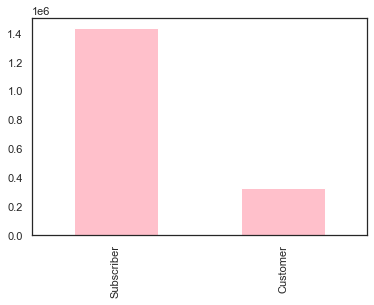

In [16]:
#plot for an overview on the Subscriber-Customer ratio
boston_2018_data_clean.user_type.value_counts().plot(kind="bar",color="pink")

In [17]:
boston_2018_data_clean.user_type.value_counts()

Subscriber    1436677
Customer       331129
Name: user_type, dtype: int64

our main income is from Subscribers. 3/4 from all our users are Subscribers. We need to make sure that we keep our Subscribers. Customers are potential Subscribers that is why we have to make sure that we can reach as many customers as possible and make teir experience on our bikes as good as possible.

In [28]:
#create dummy variables for user_type so we can plot them 
boston_2018_with_dummies=pd.get_dummies(boston_2018_data_clean, columns=['user_type'])
boston_2018_with_dummies

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,date,weekday,hour,month,Weekday_name,month_name,Bike_Anzahl,user_type_Customer,user_type_Subscriber
0,2018-01-01 00:16:33,2018-01-01 00:23:01,178,107,MIT Pacific St at Purrington St,Ames St at Main St,643,2018-01-01,0,0,1,Mon,Jan,0,0,1
1,2018-01-01 00:42:00,2018-01-01 00:46:25,78,225,Union Square - Somerville,Cambridge Dept. of Public Works -147 Hampshire...,1581,2018-01-01,0,0,1,Mon,Jan,1,0,1
2,2018-01-01 00:42:44,2018-01-01 01:02:11,16,76,Back Bay T Stop - Dartmouth St at Stuart St,Central Sq Post Office / Cambridge City Hall a...,173,2018-01-01,0,0,1,Mon,Jan,2,0,1
3,2018-01-01 00:56:50,2018-01-01 01:11:06,69,177,Coolidge Corner - Beacon St @ Centre St,University Park,1772,2018-01-01,0,0,1,Mon,Jan,3,0,1
4,2018-01-01 01:07:54,2018-01-01 01:16:02,4,46,Tremont St at E Berkeley St,Christian Science Plaza - Massachusetts Ave at...,1183,2018-01-01,0,1,1,Mon,Jan,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767801,2018-12-31 23:48:46,2018-12-31 23:56:55,19,179,Park Dr at Buswell St,MIT Vassar St,4440,2018-12-31,0,23,12,Mon,Dec,1767801,0,1
1767802,2018-12-31 23:48:58,2019-01-01 03:13:49,40,40,Lewis Wharf at Atlantic Ave,Lewis Wharf at Atlantic Ave,2117,2018-12-31,0,23,12,Mon,Dec,1767802,0,1
1767803,2018-12-31 23:51:19,2019-01-01 00:17:15,68,68,Central Square at Mass Ave / Essex St,Central Square at Mass Ave / Essex St,3725,2018-12-31,0,23,12,Mon,Dec,1767803,0,1
1767804,2018-12-31 23:54:16,2018-12-31 23:57:17,352,36,Ring Rd,Copley Square - Dartmouth St at Boylston St,3605,2018-12-31,0,23,12,Mon,Dec,1767804,1,0


In [30]:
#comparing rental per hour
Subscriber_Bike_rent_hour=boston_2018_with_dummies[boston_2018_with_dummies["user_type_Subscriber"]==1].groupby(["date","hour"])["Bike_Anzahl"].nunique()
Customer_Bike_rent_hour=boston_2018_with_dummies[boston_2018_with_dummies["user_type_Customer"]==1].groupby(["date","hour"])["Bike_Anzahl"].nunique()
Subscriber_Bike_rent_hour=pd.DataFrame(Subscriber_Bike_rent_hour)
Customer_Bike_rent_hour=pd.DataFrame(Customer_Bike_rent_hour)

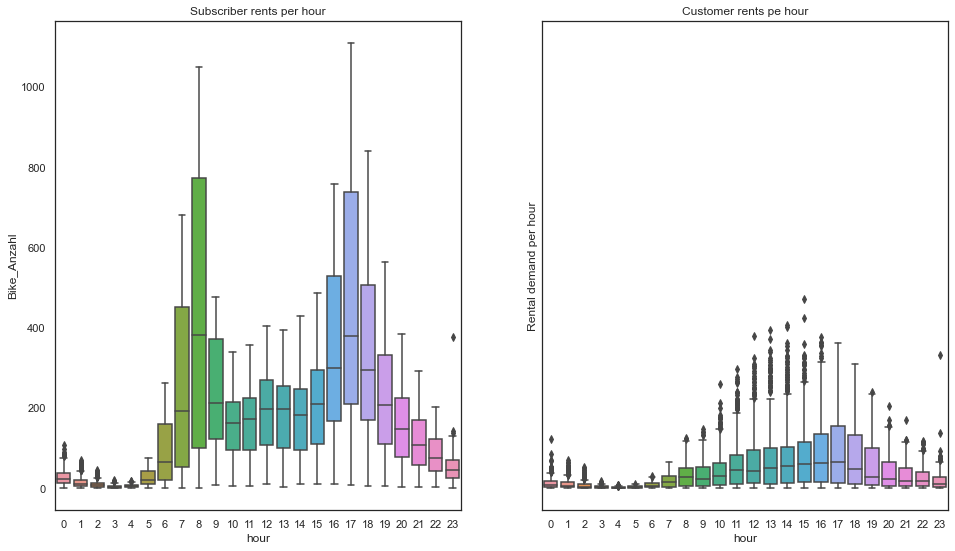

In [57]:
fig, ax = plt.subplots(figsize=(16,9), ncols=2, nrows=1, sharex=True, sharey=True)


ax[0].set_title("Subscriber rents per hour")
sns.boxplot(x=Subscriber_Bike_rent_hour.index.get_level_values(1), y=Subscriber_Bike_rent_hour["Bike_Anzahl"],ax=ax[0])


ax[1].set_title("Customer rents pe hour")
sns.boxplot(x=Customer_Bike_rent_hour.index.get_level_values(1),y=Customer_Bike_rent_hour["Bike_Anzahl"],ax=ax[1])

ax[0].set(xlabel='hour', ylabel='Rental demand (per hour)')
ax[1].set(xlabel='hour', ylabel='Rental demand (per hour)')

plt.show()

Subscribers are the most during the work start and end active. They probably use these bikes to reach their work place / school and aftewards coming back home.

In [32]:
#comparing rental weekday
Subscriber_Bike_rent_weekday=boston_2018_with_dummies[boston_2018_with_dummies["user_type_Subscriber"]==1].groupby(["date","weekday"])["Bike_Anzahl"].nunique()
Customer_Bike_rent_weekday=boston_2018_with_dummies[boston_2018_with_dummies["user_type_Customer"]==1].groupby(["date","weekday"])["Bike_Anzahl"].nunique()
Subscriber_Bike_rent_weekday=pd.DataFrame(Subscriber_Bike_rent_weekday)
Customer_Bike_rent_weekday=pd.DataFrame(Customer_Bike_rent_weekday)

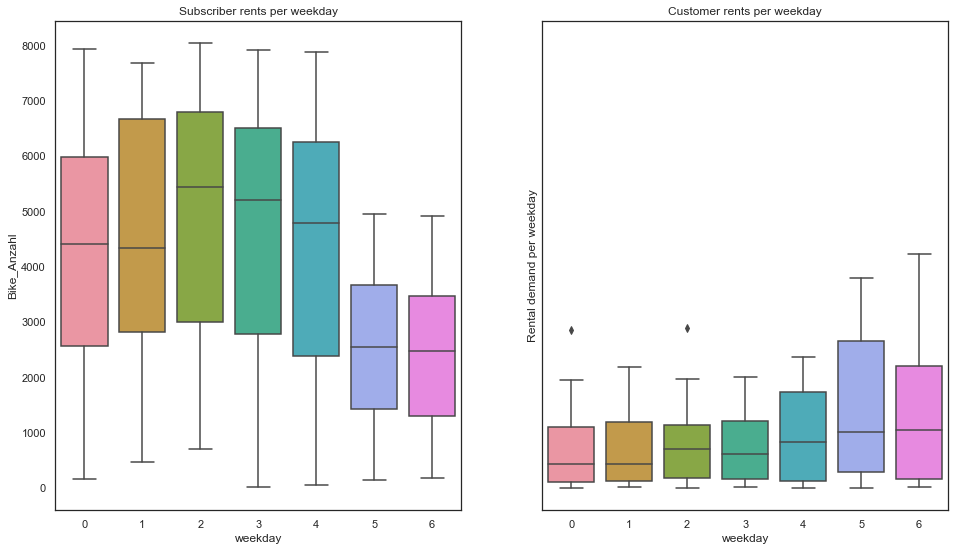

In [63]:
#plot comparing rental weekday
fig, ax = plt.subplots(figsize=(16,9), ncols=2, nrows=1, sharex=True, sharey=True)


ax[0].set_title("Subscriber rents per weekday")
sns.boxplot(x=Subscriber_Bike_rent_weekday.index.get_level_values(1), y=Subscriber_Bike_rent_weekday["Bike_Anzahl"],ax=ax[0])


ax[1].set_title("Customer rents per weekday")
sns.boxplot(x=Customer_Bike_rent_weekday.index.get_level_values(1),y=Customer_Bike_rent_weekday["Bike_Anzahl"],ax=ax[1])


ax[0].set(xlabel='weekday', ylabel='Rental demand (per weekday)')
ax[1].set(xlabel='weekday', ylabel='Rental demand (per weekday)')

plt.show()

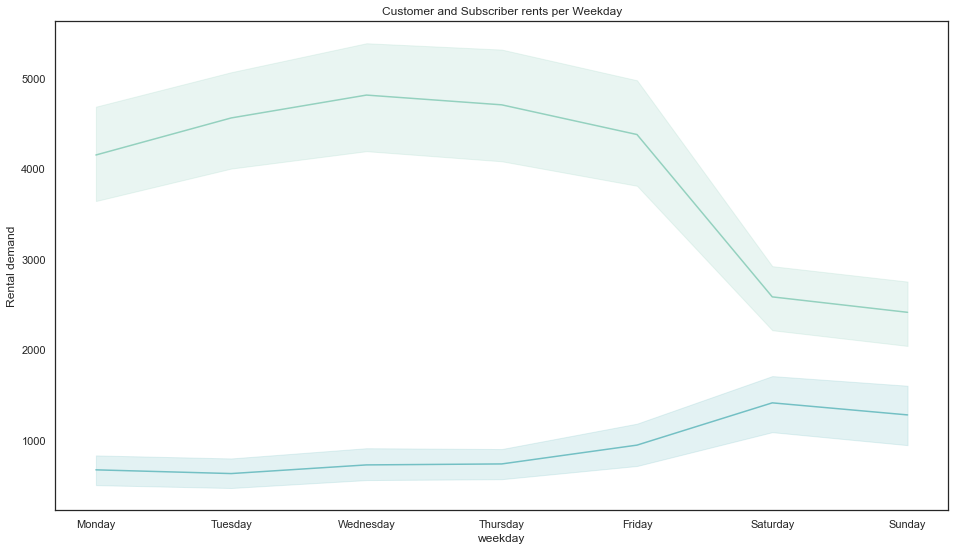

In [40]:
#emphazising the different behavior of Subscribers and Customers
fig, ax = plt.subplots(figsize=(16,9), ncols=1, nrows=1, sharex=True, sharey=True)


#ax.set_title("Subscriber rents per hour")
sns.lineplot(x=Subscriber_Bike_rent_weekday.index.get_level_values(1), y=Subscriber_Bike_rent_weekday["Bike_Anzahl"],ax=ax)


ax.set_title("Customer and Subscriber rents per Weekday")
sns.lineplot(x=Customer_Bike_rent_weekday.index.get_level_values(1),y=Customer_Bike_rent_weekday["Bike_Anzahl"],ax=ax)

plt.ylabel('Rental demand')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

## Most popular stations
### Most Popular Start Stations

In [ ]:
#start & end over the whole year
start_station_list = boston_2018_trip_geodata_clean["start_station_name"].unique()
end_station_list = boston_2018_trip_geodata_clean["end_station_name"].unique()

freq1 = boston_2018_trip_geodata_clean['start_station_name'].value_counts()  
freq2 = boston_2018_trip_geodata_clean['end_station_name'].value_counts()

freq1pd = pd.DataFrame({
                        'anzahl': freq1
                       })

In [ ]:
# counts the frequency of the station names during a specific hour over the whole year
freq_h = pd.DataFrame({
    0: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 0]['start_station_name'].value_counts(),
    1: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 1]['start_station_name'].value_counts(), 
    2: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 2]['start_station_name'].value_counts(), 
    3: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 3]['start_station_name'].value_counts(), 
    4: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 4]['start_station_name'].value_counts(), 
    5: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 5]['start_station_name'].value_counts(), 
    6: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 6]['start_station_name'].value_counts(), 
    7: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 7]['start_station_name'].value_counts(), 
    8: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 8]['start_station_name'].value_counts(), 
    9: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 9]['start_station_name'].value_counts(), 
    10: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 10]['start_station_name'].value_counts(), 
    11: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 11]['start_station_name'].value_counts(), 
    12: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 12]['start_station_name'].value_counts(), 
    13: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 13]['start_station_name'].value_counts(), 
    14: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 14]['start_station_name'].value_counts(), 
    15: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 15]['start_station_name'].value_counts(), 
    16: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 16]['start_station_name'].value_counts(), 
    17: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 17]['start_station_name'].value_counts(), 
    18: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 18]['start_station_name'].value_counts(), 
    19: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 19]['start_station_name'].value_counts(), 
    20: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 20]['start_station_name'].value_counts(), 
    21: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 21]['start_station_name'].value_counts(), 
    22: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 22]['start_station_name'].value_counts(), 
    23: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 23]['start_station_name'].value_counts()
}); 
freq_h = freq_h.fillna(0)
freq_h.head(5)

In [ ]:
# calculate the sum per row
most_pop = np.empty(24)
freq_h['sum'] = 0

for j in range(246):
    for i in range(24):
        most_pop[i] = freq_h[i][j]
    freq_h['sum'][j] = most_pop.sum()

freq_h.head(5)

In [ ]:
# select the most popular start station
most_freq_h = freq_h[freq_h['sum'] > 15000]
most_freq_h.head(5)

In [ ]:
# plot
figure, axes = plt.subplots(24, 1, figsize=(150, 200), sharey=True)

sns.barplot(x = most_freq_h.index, y=0, data=most_freq_h, ax=axes[0], palette="OrRd")
axes[0].set_title("Most popular start stations")
sns.barplot(x = most_freq_h.index , y=1, data=most_freq_h, ax=axes[1], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=2, data=most_freq_h, ax=axes[2], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=3, data=most_freq_h, ax=axes[3], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=4, data=most_freq_h, ax=axes[4], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=5, data=most_freq_h, ax=axes[5], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=6, data=most_freq_h, ax=axes[6], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=7, data=most_freq_h, ax=axes[7], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=8, data=most_freq_h, ax=axes[8], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=9, data=most_freq_h, ax=axes[9], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=10, data=most_freq_h, ax=axes[10], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=11, data=most_freq_h, ax=axes[11], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=12, data=most_freq_h, ax=axes[12], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=13, data=most_freq_h, ax=axes[13], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=14, data=most_freq_h, ax=axes[14], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=15, data=most_freq_h, ax=axes[15], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=16, data=most_freq_h, ax=axes[16], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=17, data=most_freq_h, ax=axes[17], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=18, data=most_freq_h, ax=axes[18], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=19, data=most_freq_h, ax=axes[19], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=20, data=most_freq_h, ax=axes[20], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=21, data=most_freq_h, ax=axes[21], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=22, data=most_freq_h, ax=axes[22], palette="OrRd")
sns.barplot(x = most_freq_h.index , y=23, data=most_freq_h, ax=axes[23], palette="OrRd")

### Most Popular End Stations

In [ ]:
freq_z = pd.DataFrame({
    0: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 0]['end_station_name'].value_counts(),
    1: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 1]['end_station_name'].value_counts(), 
    2: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 2]['end_station_name'].value_counts(), 
    3: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 3]['end_station_name'].value_counts(),
    4: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 4]['end_station_name'].value_counts(), 
    5: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 5]['end_station_name'].value_counts(), 
    6: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 6]['end_station_name'].value_counts(), 
    7: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 7]['end_station_name'].value_counts(), 
    8: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 8]['end_station_name'].value_counts(), 
    9: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 9]['end_station_name'].value_counts(), 
    10: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 10]['end_station_name'].value_counts(), 
    11: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 11]['end_station_name'].value_counts(), 
    12: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 12]['end_station_name'].value_counts(), 
    13: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 13]['end_station_name'].value_counts(), 
    14: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 14]['end_station_name'].value_counts(),
    15: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 15]['end_station_name'].value_counts(), 
    16: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 16]['end_station_name'].value_counts(), 
    17: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 17]['end_station_name'].value_counts(),
    18: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 18]['end_station_name'].value_counts(), 
    19: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 19]['end_station_name'].value_counts(), 
    20: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 20]['end_station_name'].value_counts(), 
    21: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 21]['end_station_name'].value_counts(),
    22: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 22]['end_station_name'].value_counts(), 
    23: boston_2018_trip_geodata_clean[boston_2018_trip_geodata_clean["hour"] == 23]['end_station_name'].value_counts() 
})

freq_z = freq_z.fillna(0)
freq_z.head(5)

In [ ]:
# calculate the sum 
most_pop_e = np.empty(24)
freq_z['sum'] = 0

for j in range(246):
    for i in range(24):
        most_pop_e[i] = freq_z[i][j]
    freq_z['sum'][j] = most_pop_e.sum()

freq_z.head(5)

In [ ]:
# select the most popular
most_freq_z = freq_z[freq_z['sum'] > 15000]
most_freq_z.head(5)

In [ ]:
figure2, axes = plt.subplots(24, 1, figsize=(150, 200), sharey=True)

sns.barplot(x = most_freq_z.index, y=0, data=most_freq_z, ax=axes[0], palette="OrRd")
axes[0].set_title("Most popular end stations")
sns.barplot(x = most_freq_z.index , y=1, data=most_freq_z, ax=axes[1], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=2, data=most_freq_z, ax=axes[2], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=3, data=most_freq_z, ax=axes[3], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=4, data=most_freq_z, ax=axes[4], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=5, data=most_freq_z, ax=axes[5], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=6, data=most_freq_z, ax=axes[6], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=7, data=most_freq_z, ax=axes[7], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=8, data=most_freq_z, ax=axes[8], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=9, data=most_freq_z, ax=axes[9], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=10, data=most_freq_z, ax=axes[10], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=11, data=most_freq_z, ax=axes[11], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=12, data=most_freq_z, ax=axes[12], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=13, data=most_freq_z, ax=axes[13], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=14, data=most_freq_z, ax=axes[14], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=15, data=most_freq_z, ax=axes[15], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=16, data=most_freq_z, ax=axes[16], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=17, data=most_freq_z, ax=axes[17], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=18, data=most_freq_z, ax=axes[18], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=19, data=most_freq_z, ax=axes[19], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=20, data=most_freq_z, ax=axes[20], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=21, data=most_freq_z, ax=axes[21], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=22, data=most_freq_z, ax=axes[22], palette="OrRd")
sns.barplot(x = most_freq_z.index , y=23, data=most_freq_z, ax=axes[23], palette="OrRd")

### Combine most popular start and end station

In [ ]:
for j in range(246):
    for i in range(24):
        freq_h[i][j]=freq_h[i][j]+freq_z[i][j]
freq_h

In [ ]:
# calculate the sum 
most_pop_e = np.empty(24)
freq_h['sum'] = 0

for j in range(246):
    for i in range(24):
        most_pop_e[i] = freq_h[i][j]
    freq_h['sum'][j] = most_pop_e.sum()
freq_h.head(5)

In [ ]:
freq_h = freq_h[freq_h["sum"]>30000]
freq_h

Each barplot represents an hour. On the x-axis are the different most popular stations. Zoom in to read the axis labelling.

In [ ]:
figure, axes = plt.subplots(24, 1, figsize=(150, 200), sharey=True)

sns.barplot(x = freq_h.index, y=0, data=freq_h, ax=axes[0], palette="OrRd")
axes[0].set_title("Most popular stations")
sns.barplot(x = freq_h.index , y=1, data=freq_h, ax=axes[1], palette="OrRd")
sns.barplot(x = freq_h.index , y=2, data=freq_h, ax=axes[2], palette="OrRd")
sns.barplot(x = freq_h.index , y=3, data=freq_h, ax=axes[3], palette="OrRd")
sns.barplot(x = freq_h.index , y=4, data=freq_h, ax=axes[4], palette="OrRd")
sns.barplot(x = freq_h.index , y=5, data=freq_h, ax=axes[5], palette="OrRd")
sns.barplot(x = freq_h.index , y=6, data=freq_h, ax=axes[6], palette="OrRd")
sns.barplot(x = freq_h.index , y=7, data=freq_h, ax=axes[7], palette="OrRd")
sns.barplot(x = freq_h.index , y=8, data=freq_h, ax=axes[8], palette="OrRd")
sns.barplot(x = freq_h.index , y=9, data=freq_h, ax=axes[9], palette="OrRd")
sns.barplot(x = freq_h.index , y=10, data=freq_h, ax=axes[10], palette="OrRd")
sns.barplot(x = freq_h.index , y=11, data=freq_h, ax=axes[11], palette="OrRd")
sns.barplot(x = freq_h.index , y=12, data=freq_h, ax=axes[12], palette="OrRd")
sns.barplot(x = freq_h.index , y=13, data=freq_h, ax=axes[13], palette="OrRd")
sns.barplot(x = freq_h.index , y=14, data=freq_h, ax=axes[14], palette="OrRd")
sns.barplot(x = freq_h.index , y=15, data=freq_h, ax=axes[15], palette="OrRd")
sns.barplot(x = freq_h.index , y=16, data=freq_h, ax=axes[16], palette="OrRd")
sns.barplot(x = freq_h.index , y=17, data=freq_h, ax=axes[17], palette="OrRd")
sns.barplot(x = freq_h.index , y=18, data=freq_h, ax=axes[18], palette="OrRd")
sns.barplot(x = freq_h.index , y=19, data=freq_h, ax=axes[19], palette="OrRd")
sns.barplot(x = freq_h.index , y=20, data=freq_h, ax=axes[20], palette="OrRd")
sns.barplot(x = freq_h.index , y=21, data=freq_h, ax=axes[21], palette="OrRd")
sns.barplot(x = freq_h.index , y=22, data=freq_h, ax=axes[22], palette="OrRd")
sns.barplot(x = freq_h.index , y=23, data=freq_h, ax=axes[23], palette="OrRd")

### Map the most popular stations overall 
On this map you can see the most popular stations overall. The stations are represented by means of markers. You can click on a marker to see the name of the station. Switch on the tilelayer 'openstreetmap' to identify interesting places like an  university nearby a station.

In [ ]:
# shows the most popular stations overall
overall = pd.DataFrame({
    "Anzahl": freq_h["sum"]
})
overall

In [ ]:
most_pop_stations = folium.Map(location=(42.337510, -71.067966), zoom_start=12)

boston_and_greater = r'boston_and_greater.json'
# Boston = r'ZIP_Codes.geojson'
# Cambridge = r'Cambridge_Zipcodes.geojson'
# Somerville = r'somerville.json'
# Brookline = r'brookline.json'

#add station markers
folium.Marker(
    [42.3625, -71.08822], popup="<i>Ames St at Main St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.34807412, -71.07657015], popup="<i>Back Bay T Stop - Dartmouth St at Stuart St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.35082681, -71.08981088], popup="<i>Beacon St at Massachusetts Ave</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.35892, -71.08981088], popup="<i>Boston City Hall - 28 State St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.36125722, -71.06528744], popup="<i>Cambridge St at Joy St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.366426, -71.105495], popup="<i>Central Sq Post Office / Cambridge City Hall at Mass Ave / Pleasant St	</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.36507, -71.1031], popup="<i>Central Square at Mass Ave / Essex St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.36079297, -71.07118962], popup="<i>Charles Circle - Charles St at Cambridge St	</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.34366582, -71.08582377], popup="<i>Christian Science Plaza - Massachusetts Ave at Westland Ave</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.34992828, -71.07739207], popup="<i>Copley Square - Dartmouth St at Boylston St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.362811, -71.056067], popup="<i>Cross St at Hanover St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.373268, -71.118579], popup="<i>Harvard Square at Mass Ave/ Dunster</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.36242784, -71.08495474], popup="<i>Kendall T</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.348706, -71.097009], popup="<i>Kenmore Square</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.370677, -71.076529], popup="<i>Lechmere Station at Cambridge St / First St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.3595732, -71.10129476], popup="<i>MIT Pacific St at Purrington St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.36213123, -71.09115601], popup="<i>MIT Stata Center at Vassar St / Main St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.35560121, -71.10394478], popup="<i>MIT Vassar St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.3581, -71.093198], popup="<i>MIT at Mass Ave / Amherst St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.365673, -71.064263], popup="<i>Nashua Street at Red Auerbach Way</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.348717, -71.085954], popup="<i>Newbury St at Hereford St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.366277, -71.09169], popup="<i>One Kendall Square at Hampshire St / Portland St</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.352175, -71.055547], popup="<i>South Station - 700 Atlantic Ave</i>"
).add_to(most_pop_stations)
folium.Marker(
    [42.36264779, -71.10006094], popup="<i>University Park</i>"
).add_to(most_pop_stations)

#add layers
most_pop_stations.choropleth(
    name="Greater Boston",
    geo_data='boston_and_greater.json',
    fill_color="grey",
    fill_opacity=0.7,
    line_opacity=1.0
)
most_pop_stations.choropleth(
    name="Boston",
    geo_data='ZIP_Codes.geojson',
    fill_color="blue",
    fill_opacity=0.7,
    line_opacity=1.0
)
most_pop_stations.choropleth(
    name="Cambridge",
    geo_data='Cambridge_Zipcodes.geojson',
    fill_color="red",
    fill_opacity=0.7,
    line_opacity=1.0
)
most_pop_stations.choropleth(
    name="Somerville",
    geo_data='somerville.json',
    fill_color="green",
    fill_opacity=0.7,
    line_opacity=1.0
)
most_pop_stations.choropleth(
    name="Brookline",
    geo_data='brookline.json',
    fill_color="purple",
    fill_opacity=0.7,
    line_opacity=1.0
)


#add tilelayers 
folium.TileLayer('cartodbpositron').add_to(most_pop_stations)
folium.TileLayer('Stamen Terrain').add_to(most_pop_stations)
folium.TileLayer('Openstreetmap').add_to(most_pop_stations)
folium.LayerControl().add_to(most_pop_stations)
               
display(most_pop_stations)

# 3 Predictive Analytics

To start the predictive analytics, we will first need to import some modules from sklearn

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## 3.1 Model Building

We now want to extract the features we have selected in **3.1 Feature Engineering** in our report.
These are the month, weekday, hour, max temperature (or min temperature, just one temperature referece) and precipitation.

As we want to predict hourly values, we also have to extract these values and possibly manipulate them to be hourly.
We do that by taking the median of the features needed to be manipulated, so the median of max_temp and precip.

We then take a look at our new dataset

In [ ]:
grouped_hourly_data = boston_2018_trip_geodata_with_temp_clean.groupby(["month", "weekday", "hour"]).median()[["max_temp", "precip"]]
grouped_hourly_data

As we now have our features, we will need to create the dependent variable, so the data we want to predict with our features. For that we choose the demand of bikes per hour, so the amount of trips started in an hour. 

In [ ]:
grouped_amount_data = boston_2018_trip_geodata_with_temp_clean.groupby(["month", "weekday", "hour"]).count()["start_time"]
grouped_amount_data.rename("amount", inplace=True)
grouped_amount_data

We will now combine these two datasets into a single one.

In [ ]:
grouped_data = pd.concat([grouped_hourly_data, grouped_amount_data], axis=1)
grouped_data

When we look at the data, we notice that our dataset has three indices. To better work with it, we reset it to a simple
integer index counting the values.

In [ ]:
grouped_data = grouped_data.reset_index()
grouped_data

We then split our data up into the x values, which are the features, and the y values, which is the value to be predicted.

So the x values are the independent variables and the y values are the dependent variable.

In [ ]:
x_entire = grouped_data[["weekday", "hour", "month", "max_temp", "precip"]]
y_entire = grouped_data["amount"]

We also create a standardized and scaled version of the x values with mean 0 and variance 1.

In [ ]:
norm = StandardScaler()
x_entire_norm = norm.fit_transform(x_entire)
x_entire_norm

As we have to decide on a type of regression, we want to take a look at relationships between the features and the variable to predict. We do that by plotting some of them one by one.

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(grouped_data["hour"].values, grouped_data["amount"].values, marker='x')
ax.set_xlabel("Hour")
ax.set_ylabel("Amount of bikes used")

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(grouped_data["month"], grouped_data["amount"], marker='x',)
ax.set_xlabel("Month")
ax.set_ylabel("Amount of bikes used")

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(grouped_data["max_temp"], grouped_data["amount"], marker='x',)
ax.set_xlabel("Temperature")
ax.set_ylabel("Amount of bikes used")

While the temperature data seems to have somewhat of a linear relationship with the amount, especially the temporal data is pretty obviously not linear. But if we put all these features together, what kind of relationship will come out? We will take that into account when deciding our selection of three models.

To be able to use this dataset for regression, we first have to split it up in a training set, a holdout set and a validation set.

A **training set** (50% of the data) to train the initial model, a **holdout set** (20% of the data) to adjust the hyperparameters and then the **validation set** (30& of the data) to finally evaluate the performance of the model.

In [ ]:
x_train_n_full, x_test_n, y_train_n_full, y_test_n = train_test_split(x_entire_norm, y_entire, test_size=0.3,random_state=40)
x_train_n, x_holdout_n, y_train_n, y_holdout_n = train_test_split(x_train_n_full, y_train_n_full, test_size = 0.2/0.7, random_state=40)

x_train_full, x_test, y_train_full, y_test = train_test_split(x_entire, y_entire, test_size=0.3,random_state=40)
x_train, x_holdout, y_train, y_holdout = train_test_split(x_train_full, y_train_full, test_size = 0.2/0.7, random_state=40)

## 3.2 Model Evaluation

## RBF Kernel in SVR

In [ ]:
model_svr = svm.SVR(kernel="rbf", C=100.0, coef0=1.0)
model_svr.fit(x_train_n, y_train_n)

In [ ]:
y_predict = model_svr.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = mean_squared_error(y_pred=y_predict, y_true=y_test_n)
determination = r2_score(y_pred=y_predict, y_true=y_test_n)
print("Mean absolute error: ", mae)
print("Mean squared error: ", mse)
print("R² = ", determination)

In [ ]:
results_rmse = np.zeros(20)
results_avge = np.zeros(20)
for i in range(20):
        model_svr = svm.SVR(kernel="rbf", C = 1.0 + i, gamma=0.1)
        svr_reg = model_svr.fit(x_train_n, y_train_n)
        y_predict = model_svr.predict(x_holdout_n)
        rmse = (mean_squared_error(y_pred=y_predict, y_true=y_holdout_n))**0.5
        avge = np.average(y_holdout_n - y_predict)
        results_rmse[i] = rmse
        results_avge[i] = avge
    
plt.plot(np.arange(1, 21), results_rmse)
plt.show()
plt.plot(np.arange(1,21), results_avge)
plt.show()

In [ ]:
results_rmse = np.zeros(20)
results_avge = np.zeros(20)
for i in range(20):
        model_svr = svm.SVR(kernel="rbf", C = 1.0 + i, gamma=0.01)
        svr_reg = model_svr.fit(x_train_n, y_train_n)
        y_predict = model_svr.predict(x_holdout_n)
        rmse = (mean_squared_error(y_pred=y_predict, y_true=y_holdout_n))**0.5
        avge = np.average(y_holdout_n - y_predict)
        results_rmse[i] = rmse
        results_avge[i] = avge
    
plt.plot(np.arange(1, 21), results_rmse)
plt.show()
plt.plot(np.arange(1,21), results_avge)
plt.show()

In [ ]:
results_rmse = np.zeros(20)
results_avge = np.zeros(20)
for i in range(20):
        model_svr = svm.SVR(kernel="rbf", C = 1.0 + i, gamma=0.001)
        svr_reg = model_svr.fit(x_train_n, y_train_n)
        y_predict = model_svr.predict(x_holdout_n)
        rmse = (mean_squared_error(y_pred=y_predict, y_true=y_holdout_n))**0.5
        avge = np.average(y_holdout_n - y_predict)
        results_rmse[i] = rmse
        results_avge[i] = avge
    
plt.plot(np.arange(1, 21), results_rmse)
plt.show()
plt.plot(np.arange(1,21), results_avge)
plt.show()

In [ ]:
results_rmse_train = np.zeros(20)
results_rmse_test = np.zeros(20)
results_rmse_holdout = np.zeros(20)
results_avge_train = np.zeros(20)
results_avge_test = np.zeros(20)
results_avge_holdout = np.zeros(20)
for i in range(20):
    model_svr = svm.SVR(kernel="rbf", C=1.0+i)
    svr_reg = model_svr.fit(x_train_n, y_train_n)
    y_predict_train = model_svr.predict(x_train_n)
    y_predict_test = model_svr.predict(x_test_n)
    y_predict_holdout = model_svr.predict(x_holdout_n)
    
    results_rmse_train[i] = (mean_squared_error(y_pred=y_predict_train, y_true=y_train_n))**0.5
    results_rmse_test[i] = (mean_squared_error(y_pred=y_predict_test, y_true=y_test_n))**0.5
    results_rmse_holdout[i] = (mean_squared_error(y_pred=y_predict_holdout, y_true=y_holdout_n))**0.5
    results_avge_train[i] = np.average(y_train_n - y_predict_train)
    results_avge_test[i] = np.average(y_test_n - y_predict_test)
    results_avge_holdout[i] = np.average(y_holdout_n - y_predict_holdout)
    
plt.plot(np.arange(1, 21), results_rmse_train, label="Train")
plt.plot(np.arange(1, 21), results_rmse_test, label="Test")
plt.plot(np.arange(1, 21), results_rmse_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()
plt.plot(np.arange(1,21), results_avge_train, label="Train")
plt.plot(np.arange(1,21), results_avge_test, label="Test")
plt.plot(np.arange(1,21), results_avge_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()

In [ ]:
results_rmse_train = np.zeros(20)
results_rmse_test = np.zeros(20)
results_rmse_holdout = np.zeros(20)
results_avge_train = np.zeros(20)
results_avge_test = np.zeros(20)
results_avge_holdout = np.zeros(20)
for i in range(20):
    model_svr = svm.SVR(kernel="rbf", C=1.0+i, gamma=0.01)
    svr_reg = model_svr.fit(x_train_n, y_train_n)
    y_predict_train = model_svr.predict(x_train_n)
    y_predict_test = model_svr.predict(x_test_n)
    y_predict_holdout = model_svr.predict(x_holdout_n)
    
    results_rmse_train[i] = (mean_squared_error(y_pred=y_predict_train, y_true=y_train_n))**0.5
    results_rmse_test[i] = (mean_squared_error(y_pred=y_predict_test, y_true=y_test_n))**0.5
    results_rmse_holdout[i] = (mean_squared_error(y_pred=y_predict_holdout, y_true=y_holdout_n))**0.5
    results_avge_train[i] = np.average(y_train_n - y_predict_train)
    results_avge_test[i] = np.average(y_test_n - y_predict_test)
    results_avge_holdout[i] = np.average(y_holdout_n - y_predict_holdout)
    
plt.plot(np.arange(1, 21), results_rmse_train, label="Train")
plt.plot(np.arange(1, 21), results_rmse_test, label="Test")
plt.plot(np.arange(1, 21), results_rmse_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()
plt.plot(np.arange(1,21), results_avge_train, label="Train")
plt.plot(np.arange(1,21), results_avge_test, label="Test")
plt.plot(np.arange(1,21), results_avge_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()

In [ ]:
model_svr = svm.SVR(kernel="rbf", C=1.0)
model_svr.fit(x_train_n, y_train_n)

y_predict = model_svr.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
determination = r2_score(y_pred=y_predict, y_true=y_test_n)
print("Mean absolute error: ", mae)
print("Mean squared error: ", mse)
#print("R² = ", determination)
print("Average error:", np.average(y_test - y_predict))

In [ ]:
model_svr = svm.SVR(kernel="rbf", C=10.0)
model_svr.fit(x_train_n, y_train_n)

y_predict = model_svr.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
determination = r2_score(y_pred=y_predict, y_true=y_test_n)
print("Mean absolute error: ", mae)
print("Mean squared error: ", mse)
#print("R² = ", determination)
print("Average error:", np.average(y_test - y_predict))

In [ ]:
model_svr = svm.SVR(kernel="rbf", C=1000000.0)
model_svr.fit(x_train_n, y_train_n)

y_predict = model_svr.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
determination = r2_score(y_pred=y_predict, y_true=y_test_n)
print("Mean absolute error: ", mae)
print("Mean squared error: ", mse)
#print("R² = ", determination)
print("Average error:", np.average(y_test - y_predict))

In [ ]:
mae = np.zeros(6)
mse = np.zeros(6)
determination = np.zeros(6)
avg_error = np.zeros(6)
C=np.array([1,10,100,1000,100000,1000000])

for i in range(6):
    model_svr = svm.SVR(kernel="rbf", C=C[i], gamma=0.1)
    model_svr.fit(x_train_n, y_train_n)

    y_predict = model_svr.predict(x_test_n)

    mae[i] = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
    mse[i] = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
    determination[i] = r2_score(y_pred=y_predict, y_true=y_test_n)
    avg_error[i] = np.average(y_test - y_predict)
    print(mae[i], mse[i], determination[i], avg_error[i])

In [ ]:
mae = np.zeros(6)
mse = np.zeros(6)
determination = np.zeros(6)
avg_error = np.zeros(6)
C=np.array([1,10,100,1000,100000,1000000])

for i in range(6):
    model_svr = svm.SVR(kernel="rbf", C=C[i], gamma=0.01)
    model_svr.fit(x_train_n, y_train_n)

    y_predict = model_svr.predict(x_test_n)

    mae[i] = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
    mse[i] = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
    determination[i] = r2_score(y_pred=y_predict, y_true=y_test_n)
    avg_error[i] = np.average(y_test - y_predict)
    print(mae[i], mse[i], determination[i], avg_error[i])

In [ ]:
mae = np.zeros(6)
mse = np.zeros(6)
determination = np.zeros(6)
avg_error = np.zeros(6)
C=np.array([1,10,100,1000,100000,1000000])

for i in range(6):
    model_svr = svm.SVR(kernel="rbf", C=C[i], gamma=0.001)
    model_svr.fit(x_train_n, y_train_n)

    y_predict = model_svr.predict(x_test_n)

    mae[i] = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
    mse[i] = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
    determination[i] = r2_score(y_pred=y_predict, y_true=y_test_n)
    avg_error[i] = np.average(y_test - y_predict)
    print(mae[i], mse[i], determination[i], avg_error[i])

In [ ]:
mae = np.zeros(6)
mse = np.zeros(6)
determination = np.zeros(6)
avg_error = np.zeros(6)
C=np.array([1,10,100,1000,100000,1000000])

for i in range(6):
    model_svr = svm.SVR(kernel="rbf", C=C[i], gamma=0.0001)
    model_svr.fit(x_train_n, y_train_n)

    y_predict = model_svr.predict(x_test_n)

    mae[i] = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
    mse[i] = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
    determination[i] = r2_score(y_pred=y_predict, y_true=y_test_n)
    avg_error[i] = np.average(y_test - y_predict)
    print(mae[i], mse[i], determination[i], avg_error[i])

In [ ]:
model_svr2 = SVR(kernel = "rbf", C=100000, gamma=0.1)
model_svr2.fit(x_train_n, y_train_n)

y_predict = model_svr2.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = (mean_squared_error(y_pred=y_predict, y_true=y_test_n))**0.5
determination = r2_score(y_pred=y_predict, y_true=y_test_n)
avg_error = np.average(y_test - y_predict)
print(mae, mse, determination, avg_error)

### KNN Regression

We start by creating the `KNeighborsRegressor` of sklearn with the default parameters.
As the k-nearest-neighbor regression algorithm needs normalized and scaled data, we enter our normalized and scaled
training dataset.

In [ ]:
KNN_reg = KNeighborsRegressor(n_neighbors=5, leaf_size=30, p=2)
KNN_model = KNN_reg.fit(x_train_n, y_train_n)

Now we will test this regression algorithm on the test dataset to see its initial performance on some evaluation metrics. There is an explanation in the report for why we chose those metrics.

In [ ]:
y_predict = KNN_model.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = mean_squared_error(y_pred=y_predict, y_true=y_test_n)
rmse = mse**0.5
print("Mean absolute error: ", mae)
print("Mean squared error:", mse)
print("Root mean squared error: ", rmse)
print("Average error:", np.average(y_test_n - y_predict))

Interesting, but is this the best we can get?

To find out, we will perform a **grid search** on our holdout dataset to select the optimal hyperparameters for the model. We do that similarly for every parameter. We first go through a range of values and set the hyperparameter to each value. hen the results are plotted and we take a look at how the mean squared error and the average error developed in this value range. Finally we usually just look for the lowest y value in the plot and take that x value as a hyperparameter.

This has to be done on the holdout dataset and not on the test dataset, as otherwise it would cause data leakage due to us selecting the best value on the results itself, which distorts the actual performance.

First, we will try the **n_neighbors** hyperparameter.

In [ ]:
results_mse = np.zeros(20)
results_avge = np.zeros(20)
for i in range(20):
    KNN_reg = KNeighborsRegressor(n_neighbors=i + 1)
    KNN_model = KNN_reg.fit(x_train_n, y_train_n)
    y_predict = KNN_model.predict(x_holdout_n)
    mse = mean_squared_error(y_pred=y_predict, y_true=y_holdout_n)
    avge = np.average(y_holdout_n - y_predict)
    results_mse[i] = mse
    results_avge[i] = avge
    
plt.plot(np.arange(1, 21), results_mse)
plt.show()
plt.plot(np.arange(1,21), results_avge)
plt.show()

It seems that a value between 3 and 8 is the optimal range for **n_neighbors**. As the y value is lowest around 4, we take that value as our hyperparameter.

We then do the same with the **leaf_size** hyperparameter.

In [ ]:
results_mse = np.zeros(50)
results_avge = np.zeros(50)
for i in range(50):
    KNN_reg = KNeighborsRegressor(n_neighbors=4, leaf_size=i + 1)
    KNN_model = KNN_reg.fit(x_train_n, y_train_n)
    y_predict = KNN_model.predict(x_holdout_n)
    mse = mean_squared_error(y_pred=y_predict, y_true=y_holdout_n)
    avge = np.average(y_holdout_n - y_predict)
    results_mse[i] = mse
    results_avge[i] = avge
    
plt.plot(np.arange(1, 51), results_mse)
plt.show()
plt.plot(np.arange(1, 51), results_avge)
plt.show()

This doesn't seem to affect the mean squared error much, so we will stay with the default value for **leaf_size**.

Again, we do the same with hyperparameter **p**.

In [ ]:
results_mse = np.zeros(10)
results_avge = np.zeros(10)
for i in range(10):
    KNN_reg = KNeighborsRegressor(n_neighbors=4, leaf_size=30, p=i+1)
    KNN_model = KNN_reg.fit(x_train_n, y_train_n)
    y_predict = KNN_model.predict(x_holdout_n)
    mse = mean_squared_error(y_pred=y_predict, y_true=y_holdout_n)
    avge = np.average(y_holdout_n - y_predict)
    results_mse[i] = mse
    results_avge[i] = avge
    
plt.plot(np.arange(1, 11), results_mse)
plt.show()
plt.plot(np.arange(1,11), results_avge)
plt.show()

The default value already seems to be the best choice, so we will stay with that value as our hyperparameter **p** for this model

Before we move on to evaluating the model with the new hyperparameters, we visualize the mean squared error and the average error for the training, holdout and validation dataset across the **n_neigbors** hyperparameter to see the differences.

In [ ]:
results_mse_train = np.zeros(20)
results_mse_test = np.zeros(20)
results_mse_holdout = np.zeros(20)
results_avge_train = np.zeros(20)
results_avge_test = np.zeros(20)
results_avge_holdout = np.zeros(20)
for i in range(20):
    KNN_reg = KNeighborsRegressor(n_neighbors=i + 1)
    KNN_model = KNN_reg.fit(x_train_n, y_train_n)
    y_predict_train = KNN_model.predict(x_train_n)
    y_predict_test = KNN_model.predict(x_test_n)
    y_predict_holdout = KNN_model.predict(x_holdout_n)
    
    results_mse_train[i] = mean_squared_error(y_pred=y_predict_train, y_true=y_train_n)
    results_mse_test[i] = mean_squared_error(y_pred=y_predict_test, y_true=y_test_n)
    results_mse_holdout[i] = mean_squared_error(y_pred=y_predict_holdout, y_true=y_holdout_n)
    results_avge_train[i] = np.average(y_train_n - y_predict_train)
    results_avge_test[i] = np.average(y_test_n - y_predict_test)
    results_avge_holdout[i] = np.average(y_holdout_n - y_predict_holdout)
    
plt.plot(np.arange(1, 21), results_mse_train, label="Train")
plt.plot(np.arange(1, 21), results_mse_test, label="Test")
plt.plot(np.arange(1, 21), results_mse_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()
plt.plot(np.arange(1,21), results_avge_train, label="Train")
plt.plot(np.arange(1,21), results_avge_test, label="Test")
plt.plot(np.arange(1,21), results_avge_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()

Now, we evaluate our dataset again.

We begin by creating a new model `KNeighborsRegressor` model with the new hyperparameters. We fit in the training dataset, but also the holdout dataset into this new model. Then, we let it predict the values of the test dataset and print out the evaluation metrics.

In [ ]:
KNN_reg = KNeighborsRegressor(n_neighbors=4, leaf_size=30, p=2)
KNN_model = KNN_reg.fit(x_train_n_full, y_train_n_full)

y_predict = KNN_model.predict(x_test_n)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test_n)
mse = mean_squared_error(y_pred=y_predict, y_true=y_test_n)
rmse = mse**0.5
print("Mean absolute error: ", mae)
print("Mean squared error:", mse)
print("Root mean squared error: ", rmse)
print("Average error:", np.average(y_test_n - y_predict))

We can see that the values have improved, even though the default values were already quite close to the values found with the grid search. We can now use these values to compare this model with our two other models.

### Tree based Regression

In [ ]:
Tree_reg = DecisionTreeRegressor(max_depth=5)
tree_model = Tree_reg.fit(x_train, y_train) 

In [ ]:
y_predict = tree_model.predict(x_test)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test)
mse = mean_squared_error(y_pred=y_predict, y_true=y_test)
determination = r2_score(y_pred=y_predict, y_true=y_test)
rmse = (mean_squared_error(y_pred=y_predict, y_true=y_test))**(0.5)
print("Mean absolute error: ", mae)
print("Mean squared error: ", mse)
print("Root mean squared error: ", rmse)
#print("R² = ", determination)

In [ ]:
def find_tree_depth (x,y):
    
    # define list for collecting results
    err_train = [] 
    err_test = []
    
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)
    
    #loop over max_depth
    
    for n in np.arange(1,21): # lets test until 24 for now
        
        # fit model
        
        tree_reg = DecisionTreeRegressor(max_depth=n)
        tree_model = Tree_reg.fit(x_train, y_train)
        
        # compute errors
        
        err_train.append(mean_absolute_error(y_train, tree_model.predict(x_train)))
        err_test.append(mean_absolute_error(y_test, tree_model.predict(x_test)))


    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,21), err_train,np.arange(1,21), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Max Tree Depth")
    plt.ylabel("MAE")
    plt.title("Search over max_depth parameter",fontsize=14)
    #plt.ylim((0,1))
    plt.show()

In [ ]:
find_tree_depth (x_entire,y_entire)

In [ ]:
results_rmse = np.zeros(20)
results_avge = np.zeros(20)
for i in range(20):
    Tree_reg = DecisionTreeRegressor(max_depth=i + 1)
    tree_model = Tree_reg.fit(x_train, y_train) 
    y_predict = tree_model.predict(x_holdout)
    rmse = (mean_squared_error(y_pred=y_predict, y_true=y_holdout))**0.5
    avge = np.average(y_holdout - y_predict)
    results_rmse[i] = rmse
    results_avge[i] = avge
    
plt.plot(np.arange(1, 21), results_rmse)
plt.show()
plt.plot(np.arange(1,21), results_avge)
plt.show()

In [ ]:
results_rmse = np.zeros(50)
results_avge = np.zeros(50)
for i in range(20):
    Tree_reg = DecisionTreeRegressor(max_depth=i + 1)
    tree_model = Tree_reg.fit(x_train, y_train) 
    y_predict = tree_model.predict(x_holdout)
    rmse = (mean_squared_error(y_pred=y_predict, y_true=y_holdout))**0.5
    avge = np.average(y_holdout - y_predict)
    results_rmse[i] = rmse
    results_avge[i] = avge
    
plt.plot(np.arange(1, 51), results_rmse)
plt.show()
plt.plot(np.arange(1,51), results_avge)
plt.show()

In [ ]:
results_rmse_train = np.zeros(20)
results_rmse_test = np.zeros(20)
results_rmse_holdout = np.zeros(20)
results_avge_train = np.zeros(20)
results_avge_test = np.zeros(20)
results_avge_holdout = np.zeros(20)
for i in range(20):
    Tree_reg = DecisionTreeRegressor(max_depth=i + 1)
    tree_model = Tree_reg.fit(x_train, y_train) 
    y_predict_train = tree_model.predict(x_train)
    y_predict_test = tree_model.predict(x_test)
    y_predict_holdout = tree_model.predict(x_holdout)
    
    results_rmse_train[i] = (mean_squared_error(y_pred=y_predict_train, y_true=y_train))**0.5
    results_rmse_test[i] = (mean_squared_error(y_pred=y_predict_test, y_true=y_test))**0.5
    results_rmse_holdout[i] = (mean_squared_error(y_pred=y_predict_holdout, y_true=y_holdout))**0.5
    results_avge_train[i] = np.average(y_train_n - y_predict_train)
    results_avge_test[i] = np.average(y_test_n - y_predict_test)
    results_avge_holdout[i] = np.average(y_holdout - y_predict_holdout)
    
plt.plot(np.arange(1, 21), results_rmse_train, label="Train")
plt.plot(np.arange(1, 21), results_rmse_test, label="Test")
plt.plot(np.arange(1, 21), results_rmse_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()
plt.plot(np.arange(1,21), results_avge_train, label="Train")
plt.plot(np.arange(1,21), results_avge_test, label="Test")
plt.plot(np.arange(1,21), results_avge_holdout, label="Holdout")
plt.legend(loc="lower right")
plt.show()

In [ ]:
Tree_reg = DecisionTreeRegressor(max_depth=8)
tree_model = Tree_reg.fit(x_train_full, y_train_full) 

In [ ]:
y_predict = tree_model.predict(x_test)

mae = mean_absolute_error(y_pred=y_predict, y_true=y_test)
mse = mean_squared_error(y_pred=y_predict, y_true=y_test)
determination = r2_score(y_pred=y_predict, y_true=y_test)
rmse = (mean_squared_error(y_pred=y_predict, y_true=y_test))**(0.5)
print("Mean absolute error: ", mae)
print("Mean squared error: ", mse)
print("Root mean squared error: ", rmse)
#print("R² = ", determination)

# REST

In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime